In [1]:
from math import *
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt

## Partie Algorithmie - argument x

### Création du vecteur de départ

page numéroté num 156

In [124]:
def alp(p):
    i = np.arange(p+1)
    return (1/2) * (1 - np.cos( (2*i+1)*np.pi / (2*p+1)))

In [125]:
def bet(p):
    i = np.arange(p+1)
    return (1/2) * (1 - np.cos( 2*i*np.pi / (2*p+1)))

page numéroté num 157

In [126]:
def start_point(p):
    I = np.zeros((2*(p+1),1))
    I[:p+1,0] = alp(p)
    I[p+1:,0] = bet(p)
    return I

### Création de la Jacobienne

page numéroté num 157 puis 163

In [127]:
def a_prime_beta(p) : 
    #i verif
    i = np.arange(0,p) + 1
    #eta verif
    eta = ((2*(p-i)+1)*np.pi) / (2*p+1)
    
    #left et right verif
    left = (2*p*np.cos(p*eta)) / (np.cos(eta) + 1)
    right = (np.sin(p*eta) / np.sin(eta)) * ( 2*p + 2/(np.cos(eta) + 1))
    return left + right

In [128]:
def b_prime_alpha(p) :
    #i et teta vérif
    i = np.arange(0,p)
    teta = ( 2*(p-i)*np.pi) / (2*p+1)
    
    #left et right vérif
    left = (2*p*np.cos(p*teta)) / (np.cos(teta) - 1)
    right = (np.sin(p*teta) / np.sin(teta)) * ( 2*p - 2/(np.cos(teta) - 1))
    return left + right

In [129]:
def Jacobian_X0(p,h, x,function,eps) : 
    f = function(x,h)
    f_max = np.max(f)
    f_eps = max(f_max, eps)
    I = np.zeros(2*p)

    I[:p] = b_prime_alpha(p)
    I[p:] = a_prime_beta(p)
  
    return np.sqrt(f_eps)*np.diag(I)

### Création de l'interpolation a et b 

page numéroté num 155

In [160]:
def a(x,alpha,h, p,function, eps):
    res = 0
    for i in range(p+1):
        som = (-1)**(i+p)* np.sqrt(max(function(alpha[i],h),eps) / alpha[i])
        mul = 1 
        for j in range(p+1) :
            if i != j :
                mul = mul * ((x - alpha[j]) / (alpha[i] - alpha[j])) 
        som = som*mul
        res += som
    return res

In [161]:
def b(x,beta,h,p, function,eps):
    res = 0
    for i in range(p+1) : 
        som = (-1)**(i+p) * sqrt(max(function(beta[i],h), eps) / ( 1 - beta[i]))
        mul = 1 
        for j in range(p+1) : 
            if i != j :
                mul = mul * ((x - beta[j]) / (beta[i] - beta[j]))
        som = som*mul
        res += som
    return res

### Vecteur têta

page numéroté num 155

In [132]:
def teta_teta(x, h, p, function,eps) : 
    teta = np.zeros((2*p,1))
    alpha = x[:p]
    alpha_new = np.concatenate(( alpha, [[1]]))
    beta = x[p:]
    beta_new = np.concatenate(([[0]],beta))
    
    teta[:p] = b(alpha, beta_new, h, p, function,eps)
    teta[p:] = a(beta, alpha_new, h, p, function, eps) 
    return teta 

### Splitting node 

### Algorithme Newton-Raphson

page numéroté num 155

In [133]:
def G_hat(x,h, p, function,eps) : 
    J = Jacobian_X0(p,h,x, function, eps)
    tet = teta_teta(x, h, p, function,eps)
    d = npl.solve(J,tet)
    return x - d

In [218]:
def Newton_Raphson(p,h ,function,eps=1e-12)  :
    X0 = start_point(p)
    X = np.concatenate((X0[:p], X0[p+2:]))
    X_past = X + 2*eps
    err = 2*eps
    ERR = []
    i = 0
    while npl.norm(X-X_past)/npl.norm(X) > eps and i<20000:
        X_past = X
        X = G_hat(X,h,p,function,eps)
        i+=1
        ERR += [npl.norm(X - X_past)/npl.norm(X)]
    print("Nombre d'itérations finales : ",i)
    #print("Erreur Newton-Raphson : ", ERR[-1])
    return X, ERR, i

### Création des points d'interpolation = Lukacs

In [219]:
def polynom(x, a, b):
    sol = x*(a**2) +(1-x)*(b**2)
    return sol

### Affichage du polynome

In [220]:
def polynom_display(xn,poln, x, pol,h, real_func):
    x0 = np.linspace(0,1,100)
    
    plt.figure()
    plt.plot(x, pol, '-b')
    plt.plot(xn,poln, 'ob', label ="Points d'interpolation")
    plt.plot(x0, real_func(x0,h), '-r', label = "Fonction à interpoler")
    plt.legend()
    plt.show()   

In [221]:
def polynom_display2(xn,pol,h, real_func):
    x0 = np.linspace(0,1,100)
    
    plt.plot(xn,pol, 'ob', label ="Points d'interpolation")
    plt.plot(x0, real_func(x0,h), '-r', label = "Fonction à interpoler")
    plt.title("Interpolation de la fonction")

### Interpolation par un polynome

In [222]:
def interpol(p,h,function, eps=1e-3) :
    X, ERR, nit = Newton_Raphson(p, h, function, eps)
    X = np.concatenate((X[:p], [[1]], [[0]], X[p:]))
    
    xn = np.zeros((p+1,1))
    xn[:,0] = np.linspace(0,1,p+1)
    
    ar = X[:p+1]
    br = X[p+1:]
    
    A = a(xn, ar, h, p, function,eps )
    B = b(xn, br, h, p, function,eps )
    poln = polynom(xn, A, B)

    x = np.linspace(0,1,300)
    A_pol = a(x, ar, h, p ,function, eps)
    B_pol = b(x, br, h, p ,function, eps)
    pol = polynom(x, A_pol, B_pol)

    
    return poln, xn, ERR, pol, x, nit 

In [223]:
def erreur(xn, poln, function, h) : 
    f = function(xn, h)
    dif = np.abs(f - poln)
    n = np.shape(dif)[0]
    dif = np.reshape(dif, (n))
    xn = np.reshape(xn, (n))
    som = 0
    for i in range(n-1) : 
        som += (xn[i+1]-xn[i]) * (dif[i+1]+dif[i]) / 2
    return som 

In [140]:
def find_order(x, err) :
    return (log10(err[-1])-log10(err[0])) /  (log10(x[-1])-log10(x[0]))

## Deux variables x et t

In [141]:
def Jacobian_X0_t(p, h, x, function, eps, t) : 
    f = function(x, h, t)
    f_max = np.max(f)
    f_eps = max(f_max, eps)
    I = np.zeros(2*p)

    I[:p] = b_prime_alpha(p)
    I[p:] = a_prime_beta(p)
  
    return np.sqrt(f_eps)*np.diag(I)

In [182]:
def a_t(x, alpha, h, p, function, eps, t):
    res = 0
    for i in range(p+1):
        som = (-1)**(i+p)* np.sqrt(max(function(alpha[i], h, t),eps) / alpha[i])
        mul = 1 
        for j in range(p+1) :
            if i != j :
                mul = mul * ((x - alpha[j]) / (alpha[i] - alpha[j])) 
        som  =  som* mul
        res += som
    return res

In [184]:
def b_t(x, beta, h, p, function, eps, t):
    res = 0
    for i in range(p+1) :
        som = (-1)**(i+p) * sqrt(max(function(beta[i], h, t), eps) / ( 1 - beta[i]))
        mul = 1 
        for j in range(p+1) : 
            if i != j :
                mul = mul * ((x - beta[j]) / (beta[i] - beta[j]))
        som = som* mul
        res += som
    return res

In [185]:
def teta_teta_t(x, h, p, function, eps, t) : 
    teta = np.zeros((2*p,1))
    alpha = x[:p]
    alpha_new = np.concatenate(( alpha, [[1]]))
    beta = x[p:]
    beta_new = np.concatenate(([[0]],beta))
    
    teta[p:] = a_t(beta, alpha_new, h, p, function, eps, t) 
    teta[:p] = b_t(alpha, beta_new, h, p, function, eps, t)
    return teta 

In [186]:
def G_hat_t(x, h, p, function, eps, t) : 
    J = Jacobian_X0_t(p, h, x, function, eps, t)
    tet = teta_teta_t(x, h, p, function,eps, t)
    d = npl.solve(J,tet)
    return x - d

In [236]:
def Newton_Raphson_t(p, h, function, t, eps=1e-3)  :
    X0 = start_point(p)
    X = np.concatenate((X0[:p], X0[p+2:]))
    X_past = X + 2*eps
    err = 2*eps
    ERR = []
    i = 0
    while npl.norm(X-X_past)/npl.norm(X) > eps and i<20000:
        X_past = X
        X = G_hat_t(X, h, p, function, eps, t)
        i+=1
        ERR += [npl.norm(X - X_past)/npl.norm(X)]
    #print("Erreur Newton-Raphson : ", ERR[-1])
    return X, ERR, i

In [240]:
def interpol_t(p,h,function, t, eps=1e-12) :
    X, ERR, nit = Newton_Raphson_t(p, h, function, t, eps)
    X = np.concatenate((X[:p], [[1]], [[0]], X[p:]))
    
    xn = np.zeros((p+1,1))
    xn[:,0] = np.linspace(0,1,p+1)
    
    ar = X[:p+1]
    br = X[p+1:]
    
    A = a_t(xn, ar, h, p, function, eps, t)
    B = b_t(xn, br, h, p, function, eps, t)
    poln = polynom(xn, A, B)

    x = np.linspace(0,1,300)
    A_pol = a_t(x, ar, h, p ,function, eps, t)
    B_pol = b_t(x, br, h, p ,function, eps, t)
    pol = polynom(x, A_pol, B_pol)

    
    return poln, xn, ERR, pol, x, nit

In [192]:
def polynom_display_t(xn,poln, x, pol,h, real_func, t):
    x0 = np.linspace(0,1,100)
    
    plt.figure()
    plt.plot(x, pol, '-b')
    plt.plot(xn,poln, 'ob', label ="Points d'interpolation")
    plt.plot(x0, real_func(x0,h, t), '-r', label = "Fonction à interpoler")
    plt.legend()
    plt.show()   

In [190]:
def erreur_t(xn, poln, function, h, t) : 
    f = function(xn, h, t)
    dif = np.abs(f - poln)
    n = np.shape(dif)[0]
    dif = np.reshape(dif, (n))
    xn = np.reshape(xn, (n))
    som = 0
    for i in range(n-1) : 
        som += (xn[i+1]-xn[i]) * (dif[i+1]+dif[i]) / 2
    return som 

## Création des fonctions - variable x

#### Fonctions polynomes

In [150]:
def pol1(x,h):
    x = x*h
    return x**2+1

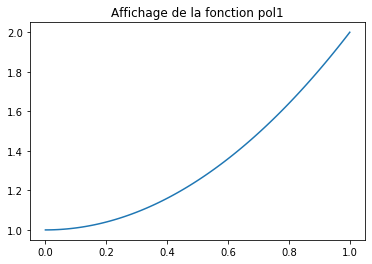

In [151]:
x = np.linspace(0,1,100)
h = 1 
plt.title("Affichage de la fonction pol1")
plt.plot(x , pol1(x,h))

In [152]:
def pol2(x,h) :
    x= x*h
    return (10**5)*(x**10)*(1-x)**7 + 0.01

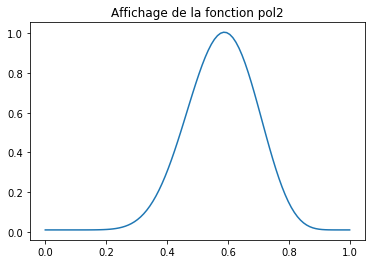

In [31]:
x = np.linspace(0,1,100)
h = 1 
plt.title("Affichage de la fonction pol2")
plt.plot(x , pol2(x,h))

In [32]:
def pol3(x,h) :
    x = x*h
    return 10*(x-1/2)**4 +3

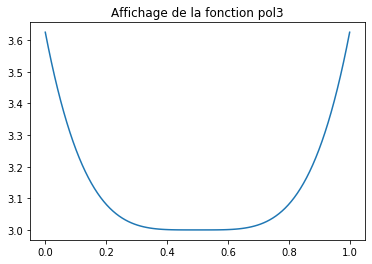

In [33]:
x = np.linspace(0,1,100)
h = 1
plt.title("Affichage de la fonction pol3")
plt.plot(x , pol3(x,h))

In [34]:
def pol4(x,h) : 
    x = x*h
    return 10**5 * (x**10)* (1-x)**7 + 0.01

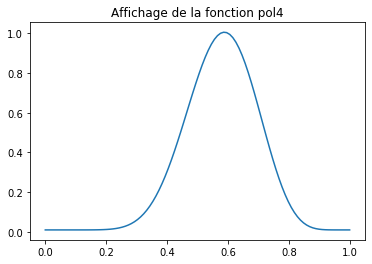

In [35]:
x = np.linspace(0,1,100)
h = 1
plt.title("Affichage de la fonction pol4")
plt.plot(x , pol4(x,h))

#### Focntions hyperboliques

In [36]:
def hyp1(x,h) :
    x=x*h
    return 1/(1-x)

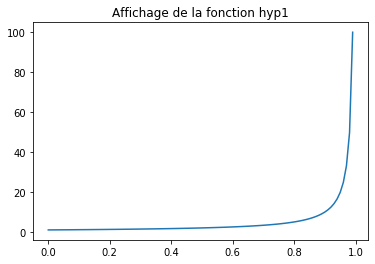

In [37]:
x = np.linspace(0,0.99,99)
h = 1
plt.title("Affichage de la fonction hyp1")
plt.plot(x , hyp1(x,h))

In [38]:
def hyp2(x,h) :
    x = x*h
    return 1/(1+25*(2*x-1)**2)

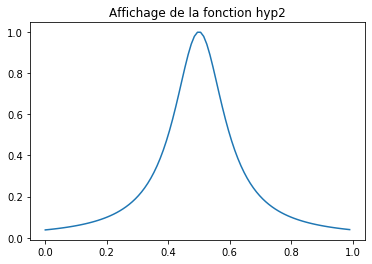

In [39]:
x = np.linspace(0,0.99,99)
h = 1
plt.title("Affichage de la fonction hyp2")
plt.plot(x , hyp2(x,h))

#### Focntions particulières

In [40]:
def absolu(x,h) : 
    x= x*h
    return np.abs(x-0.5*h)

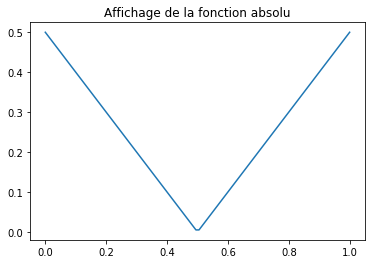

In [41]:
x = np.linspace(0,1,100)
h = 1
plt.title("Affichage de la fonction absolu")
plt.plot(x , absolu(x,h))

In [42]:
def creneau(x,h) : 
    x = x*h    
    return 0*(x<0.2*h) + 1*(x>=0.2*h)*(x<=0.6*h)+0*(x>0.6*h)

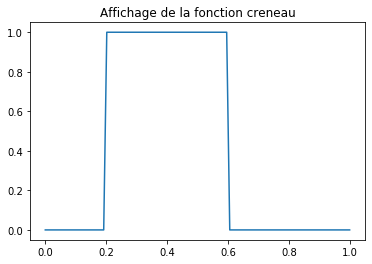

In [43]:
x = np.linspace(0,1,100)
h = 1
plt.title("Affichage de la fonction creneau")
plt.plot(x , creneau(x,h))

In [44]:
def sin_off(x,h) : 
    x = x*h 
    return np.sin(x) + 1.1

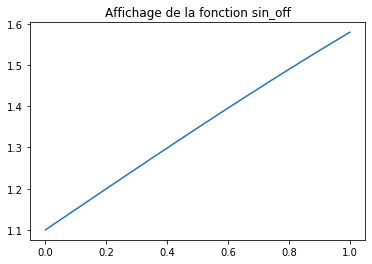

In [45]:
x = np.linspace(0,1,100)
h = 0.5
plt.title("Affichage de la fonction sin_off")
plt.plot(x , sin_off(x,h))

In [46]:
def sin_ax_b(x,h) : 
    x = x*h
    return np.sin(x) + 0.1*x + 2

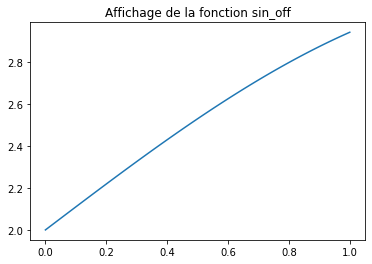

In [47]:
x = np.linspace(0,1,100)
h = 1
plt.title("Affichage de la fonction sin_off")
plt.plot(x , sin_ax_b(x,h))

In [48]:
def gaussienne(x,h) : 
    x = x*h
    return (1/(sqrt(2*pi)*0.1)) * np.exp(-(x-0.25)**2/(2*0.1**2))

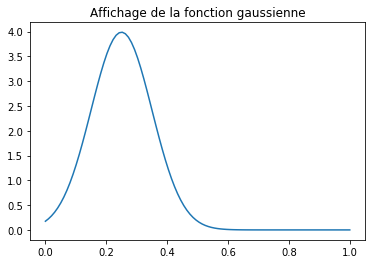

In [49]:
x = np.linspace(0,1,100)
h = 1
plt.title("Affichage de la fonction gaussienne")
plt.plot(x , gaussienne(x,h))

## Création des fonctions - variables x et t

##### Fonctions polynomiales

In [50]:
def pol1_t(x,h,t):
    x = x*h
    return x**2+1*t

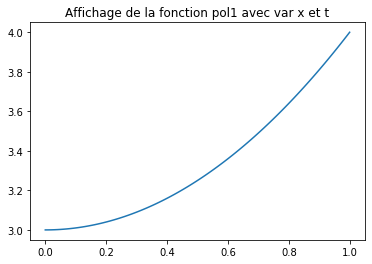

In [51]:
x = np.linspace(0,1,100)
h = 1 
t = 3
plt.title("Affichage de la fonction pol1 avec var x et t")
plt.plot(x , pol1_t(x,h,t))

In [52]:
def pol2_t(x,h,t) :
    x= x*h
    return (10**5)*(x**10)*(1-x)**7 + 0.01*t

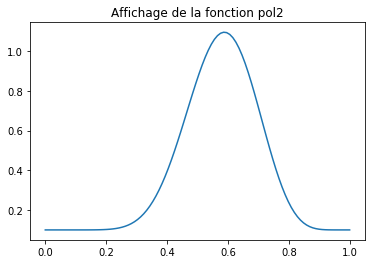

In [53]:
x = np.linspace(0,1,100)
h = 1 
t = 10
plt.title("Affichage de la fonction pol2")
plt.plot(x , pol2_t(x,h,t))

In [54]:
def pol3_t(x,h,t) :
    x = x*h
    return 10*(x-1/2)**(4*t) +3

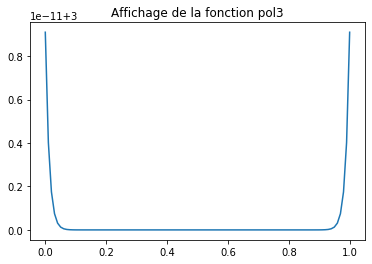

In [55]:
x = np.linspace(0,1,100)
h = 1
t = 10
plt.title("Affichage de la fonction pol3")
plt.plot(x , pol3_t(x,h,t))

In [56]:
def pol4_t(x,h,t) : 
    x = x*h
    return 10**5 * t*(x**10)* (1-x)**7 + 0.01

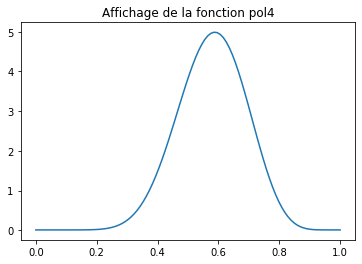

In [57]:
x = np.linspace(0,1,100)
h = 1
t = 5
plt.title("Affichage de la fonction pol4")
plt.plot(x , pol4_t(x,h,t))

##### Fonctions hyperboliques

In [58]:
def hyp1_t(x,h,t) :
    x=x*h
    return t/(1-x)

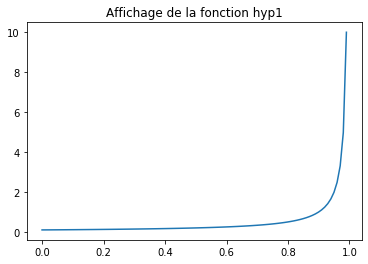

In [59]:
x = np.linspace(0,0.99,99)
h = 1
t = 0.1
plt.title("Affichage de la fonction hyp1")
plt.plot(x , hyp1_t(x,h,t))

In [60]:
def hyp2_t(x,h,t) :
    x = x*h
    return 1/(1+25*(2*x-1)**(2*t))

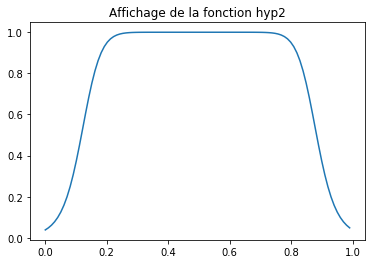

In [61]:
x = np.linspace(0,0.99,99)
h = 1
t = 6
plt.title("Affichage de la fonction hyp2")
plt.plot(x , hyp2_t(x,h,t))

##### Fonctions particulières

In [62]:
def absolu_t(x,h,t) : 
    x= x*h
    return np.abs(x-0.5*h*t)

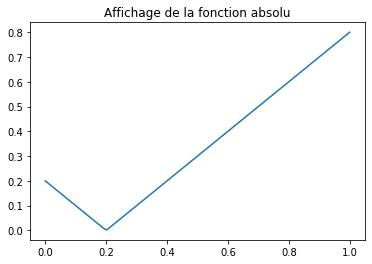

In [63]:
x = np.linspace(0,1,100)
h = 1
t = 0.4
plt.title("Affichage de la fonction absolu")
plt.plot(x , absolu_t(x,h,t))

In [64]:
def creneau_t(x,h,t) : 
    x = x*h    
    return 0*(x<0.2*h*t) + 1*(x>=0.2*h*t)*(x<=0.6*h*t)+0*(x>0.6*h*t)

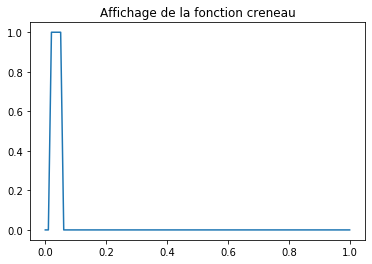

In [65]:
x = np.linspace(0,1,100)
h = 1
t = 0.1
plt.title("Affichage de la fonction creneau")
plt.plot(x , creneau_t(x,h,t))

In [66]:
def gaussienne_t(x,h,t) : 
    x = x*h
    return (1/(sqrt(2*pi)*0.1)) * np.exp(-(x-0.25)**2/(2*0.1**2*t))

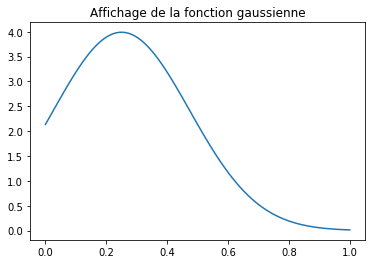

In [67]:
x = np.linspace(0,1,100)
h = 1
t = 5
plt.title("Affichage de la fonction gaussienne")
plt.plot(x , gaussienne_t(x,h,t))

## Etude de l'interpolation sur de simples polynomes ou hyperboles

##### Etude de la fonction f(x) = x**2 + 1

Nombre d'itérations finales :  4


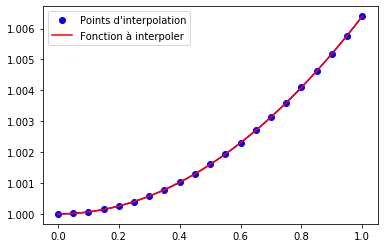

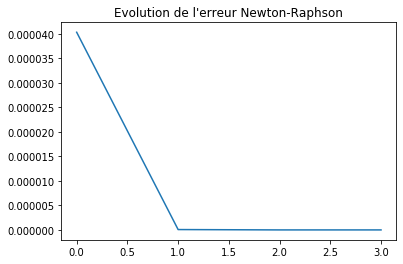

 
Calcul de l'erreur de convergence globale : 
L'erreur est =  5.38458166943201e-16


In [165]:
p = 20
h = 0.08
poln, xn, error, pol, x, nit = interpol(p,h, pol1,1e-12)
polynom_display(xn,poln,x ,pol,h,pol1)
print("Nombre d'itérations finales : ",nit)

error = np.asarray(error)
if len(error) > 3 :
    plt.figure()
    plt.plot(error)
    plt.title("Evolution de l'erreur Newton-Raphson")
    plt.show()
else :
    print("La convergence de Newton-Raphson est rapide.")
print(" ")

print("Calcul de l'erreur de convergence globale : ")
err = erreur(xn,poln,pol1,h)
print("L'erreur est = ", err)

##### Etude de la fonction f(x) = (10^5)*(x^10)*(1-x)^7 + 0.01

Nombre d'itérations finales :  4


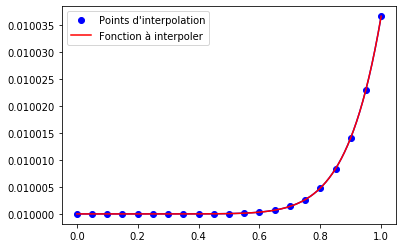

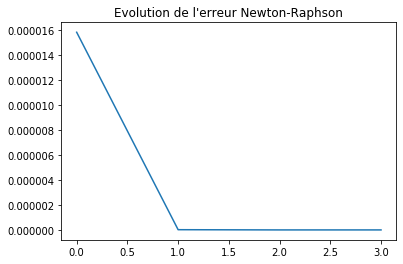

 
Calcul de l'erreur de convergence globale : 
L'erreur est =  9.80118763926896e-18


In [166]:
p = 20
h = 1/8
poln, xn, error, pol, x, nit = interpol(p,h, pol2,1e-12)
polynom_display(xn,poln , x, pol,h,pol2)
print("Nombre d'itérations finales : ",nit)


error = np.asarray(error)
if len(error) > 3 :
    plt.figure()
    plt.plot(error)
    plt.title("Evolution de l'erreur Newton-Raphson")
    plt.show()
else :
    print("La convergence de Newton-Raphson est rapide.")
print(" ")

print("Calcul de l'erreur de convergence globale : ")
err = erreur(xn,poln,pol2,h)
print("L'erreur est = ", err)

**Diminution de la valeur de h (essayer de sampler plus)**

Nombre d'itérations finales :  1


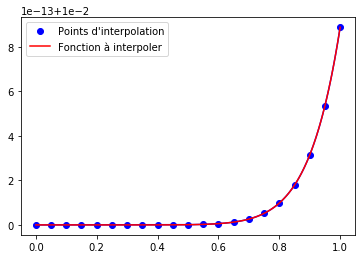

 
Calcul de l'erreur de convergence globale : 
L'erreur est =  5.204170427930421e-18


In [167]:
p = 20
h = 0.02
poln, xn, error, pol, x, nit = interpol(p,h, pol2,1e-12)
polynom_display(xn,poln , x, pol,h,pol2)
print("Nombre d'itérations finales : ",nit)


print(" ")

print("Calcul de l'erreur de convergence globale : ")
err = erreur(xn,poln,pol2,h)
print("L'erreur est = ", err)

##### Etude de la fonction f(x) = 10*(x-1/2)**4 +3

Nombre d'itérations finales :  10


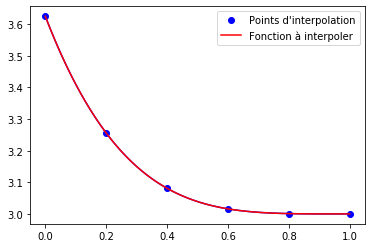

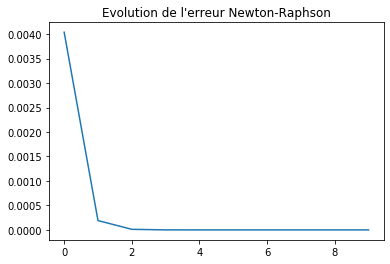

 
Calcul de l'erreur de convergence : 
L'erreur est =  7.993605777301126e-16


In [168]:
p = 5
h = 1/2
poln, xn, error, pol, x, nit = interpol(p,h, pol3,1e-12)
polynom_display(xn,poln,x, pol,h,pol3)
print("Nombre d'itérations finales : ",nit)

error = np.asarray(error)
if len(error) > 3 :
    plt.figure()
    plt.plot(error)
    plt.title("Evolution de l'erreur Newton-Raphson")
    plt.show()
else :
    print("La convergence de Newton-Raphson est rapide.")
print(" ")

print("Calcul de l'erreur de convergence : ")
err = erreur(xn,poln,pol3,h)
print("L'erreur est = ", err)

##### Etude de la fonction f(x) = 10^5 * (x^10)* (1-x)^7 + 0.01

Nombre d'itérations finales :  3


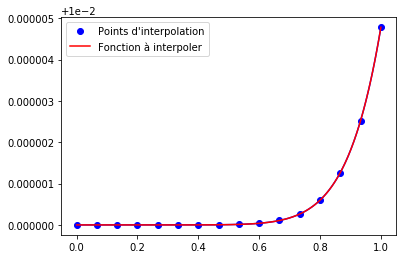

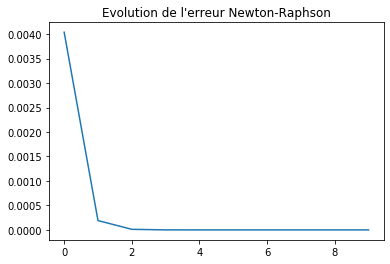

 
Calcul de l'erreur de convergence : 
L'erreur est =  6.071532165918826e-18


In [169]:
p = 15
h = 0.1
poln ,xn, ERR, pol, x, nit = interpol(p,h,pol4, eps=1e-12)
polynom_display(xn,poln, x, pol, h, pol4)
print("Nombre d'itérations finales : ",nit)

error = np.asarray(error)
if len(error) > 3 :
    plt.figure()
    plt.plot(error)
    plt.title("Evolution de l'erreur Newton-Raphson")
    plt.show()
else :
    print("La convergence de Newton-Raphson est rapide.")
print(" ")

print("Calcul de l'erreur de convergence : ")
err = erreur(xn,poln,pol4,h)
print("L'erreur est = ", err)

##### Etude de la fonction f(x) = 1/(1-x)

Nombre d'itérations finales :  8


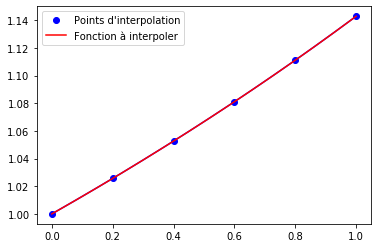

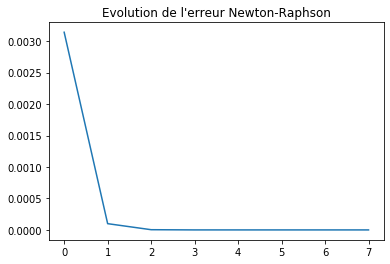

 
Calcul de l'erreur de convergence : 
L'erreur est =  1.9984014443252818e-16


In [170]:
p = 5
h = 1/8
poln, xn, error, pol, x, nit = interpol(p,h, hyp1, 1e-12)
polynom_display(xn,poln,x ,pol,h,hyp1)
print("Nombre d'itérations finales : ",nit)

error = np.asarray(error)
if len(error) > 3 :
    plt.figure()
    plt.plot(error)
    plt.title("Evolution de l'erreur Newton-Raphson")
    plt.show()
else :
    print("La convergence Newton-Raphson est rapide.")
print(" ")

print("Calcul de l'erreur de convergence : ")
err = erreur(xn,poln,hyp1,h)
print("L'erreur est = ", err)

##### Etude de la fonction f(x) = 1/(1+25*(2*x-1)**2)

Nombre d'itérations finales :  72


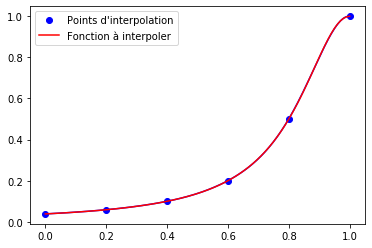

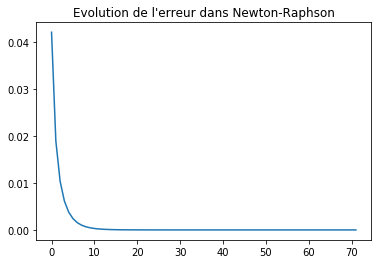

 
Calcul de l'erreur de convergence : 
L'erreur est =  0.0002704464585528809


In [171]:
p = 5
h = 1/2
poln, xn, error, pol, x, nit = interpol(p,h, hyp2,1e-12)
polynom_display(xn,poln, x, pol,h,hyp2)
print("Nombre d'itérations finales : ",nit)

error = np.asarray(error)
if len(error) > 3 :
    plt.figure()
    plt.plot(error)
    plt.title("Evolution de l'erreur dans Newton-Raphson")

    plt.show()
else :
    print("La convergence newton-Raphson est rapide.")
print(" ")

print("Calcul de l'erreur de convergence : ")
err = erreur(xn,poln,hyp2,h)
print("L'erreur est = ", err)

## Etude de l'interpolation sur des fonctions particulières

##### Etude de la fonction valeur absolu 

Nombre d'itérations finales :  73


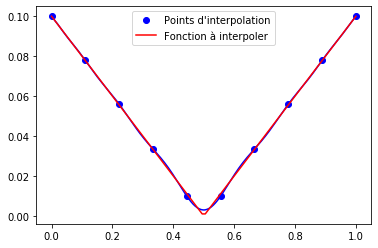

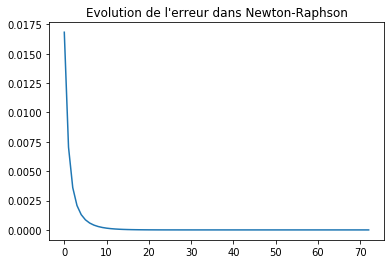

 
Calcul de l'erreur de convergence globale : 
L'erreur est =  0.000410740759182669


In [172]:
p = 9
h = 0.20
poln, xn, error, pol, x, nit = interpol(p,h, absolu,1e-12)
polynom_display(xn,poln,x ,pol,h,absolu)
print("Nombre d'itérations finales : ",nit)

error = np.asarray(error)
if len(error) > 3 :
    plt.figure()
    plt.plot(error)
    plt.title("Evolution de l'erreur dans Newton-Raphson")
    plt.show()
else :
    print("La convergence Newton-Raphson est rapide.")
print(" ")

print("Calcul de l'erreur de convergence globale : ")
err = erreur(xn,poln,absolu,h)
print("L'erreur est = ", err)

**En essayant de diminuer h**

Nombre d'itérations finales :  73


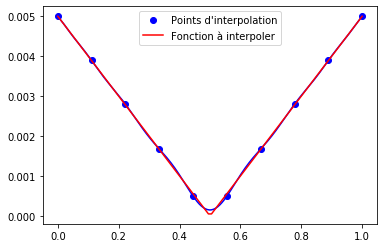

 
Calcul de l'erreur de convergence globale : 
L'erreur est =  2.0537037959132907e-05


In [173]:
p = 9
h = 0.01
poln, xn, error, pol, x, nit = interpol(p,h, absolu,1e-12)
polynom_display(xn,poln,x ,pol,h,absolu)
print("Nombre d'itérations finales : ",nit)

print(" ")

print("Calcul de l'erreur de convergence globale : ")
err = erreur(xn,poln,absolu,h)
print("L'erreur est = ", err)

##### Etude de la fonction créneau 

Nombre d'itérations finales :  9


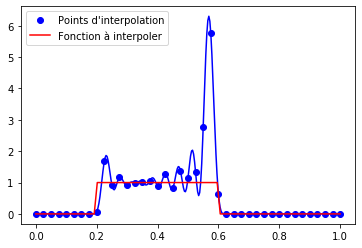

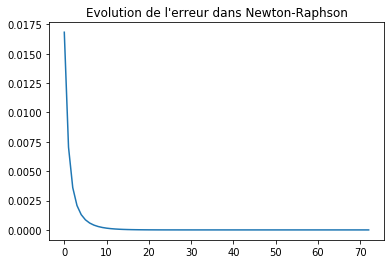

 
Calcul de l'erreur de convergence globale : 
L'erreur est =  0.2664420980836171


In [179]:
p = 40
h = 0.01
poln, xn, err, pol, x, nit = interpol(p ,h, creneau, 1e-3)
polynom_display(xn, poln,x, pol, h, creneau)
print("Nombre d'itérations finales : ",nit)

error = np.asarray(error)
if len(error) > 3 :
    plt.figure()
    plt.plot(error)
    plt.title("Evolution de l'erreur dans Newton-Raphson")
    plt.show()
else :
    print("La convergence Newton-Raphson est rapide.")
print(" ")

print("Calcul de l'erreur de convergence globale : ")
err = erreur(xn,poln,creneau,h)
print("L'erreur est = ", err)

##### Etude de la fonction sinx + offset

Nombre d'itérations finales :  7


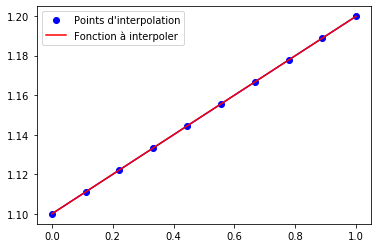

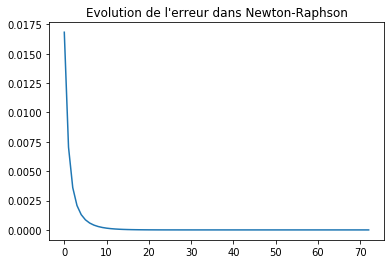

 
Calcul de l'erreur de convergence globale : 
L'erreur est =  6.291263806209222e-16


In [180]:
p = 9
h = 0.1
poln, xn, err, pol, x, nit = interpol(p ,h, sin_off, eps=1e-12)
polynom_display(xn, poln, x, pol, h, sin_off)
print("Nombre d'itérations finales : ",nit)

error = np.asarray(error)
if len(error) > 3 :
    plt.figure()
    plt.plot(error)
    plt.title("Evolution de l'erreur dans Newton-Raphson")
    plt.show()
else :
    print("La convergence Newton-Raphson est rapide.")
print(" ")

print("Calcul de l'erreur de convergence globale : ")
err = erreur(xn,poln,sin_off,h)
print("L'erreur est = ", err)

##### Etude de la gaussienne

Nombre d'itérations finales :  10


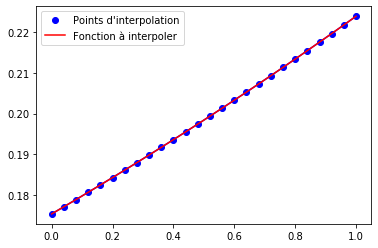

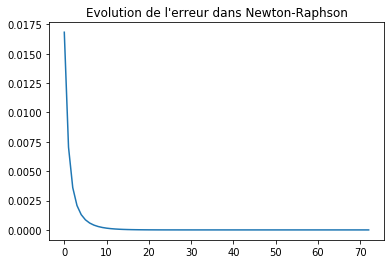

 
Calcul de l'erreur de convergence globale : 
L'erreur est =  1.3711254354120687e-16


In [181]:
p = 25
h = 0.01
poln, xn, err, pol, x, nit = interpol(p ,h, gaussienne, eps=1e-12)
polynom_display(xn, poln, x, pol, h, gaussienne)
print("Nombre d'itérations finales : ",nit)

error = np.asarray(error)
if len(error) > 3 :
    plt.figure()
    plt.plot(error)
    plt.title("Evolution de l'erreur dans Newton-Raphson")
    plt.show()
else :
    print("La convergence Newton-Raphson est rapide.")
print(" ")

print("Calcul de l'erreur de convergence globale : ")
err = erreur(xn,poln,gaussienne,h)
print("L'erreur est = ", err)

## Etude de l'interpolation de fonctions dépendant de x et de t

Nombre d'itérations finales :  3


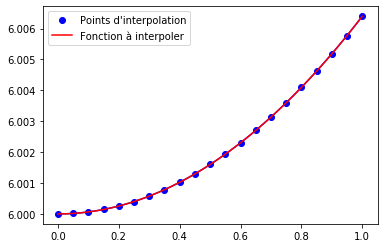

La convergence de Newton-Raphson est rapide.
 
Calcul de l'erreur de convergence globale : 
L'erreur est =  3.463895836830489e-15


In [193]:
p = 20
h = 0.08
t = 6
poln, xn, error, pol, x, nit = interpol_t(p,h, pol1_t, t, )
polynom_display_t(xn,poln,x ,pol,h,pol1_t, t)
print("Nombre d'itérations finales : ",nit)

error = np.asarray(error)
if len(error) > 3 :
    plt.figure()
    plt.plot(error)
    plt.title("Evolution de l'erreur Newton-Raphson")
    plt.show()
else :
    print("La convergence de Newton-Raphson est rapide.")
print(" ")

print("Calcul de l'erreur de convergence globale : ")
err = erreur_t(xn,poln,pol1_t,h,t)
print("L'erreur est = ", err)

## Variation de l'erreur en fonction de h, epsilon et p

##### Etude de l'erreur en fonction de epsilon

epsilon =  0.1
Nombre d'itérations finales :  1


<Figure size 432x288 with 0 Axes>

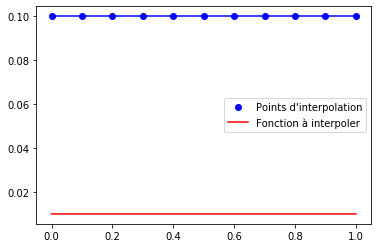

epsilon =  0.01
Nombre d'itérations finales :  1


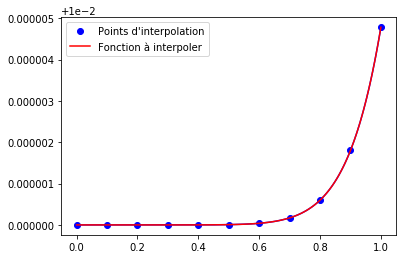

epsilon =  0.001
Nombre d'itérations finales :  1


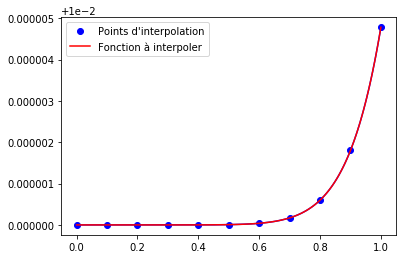

epsilon =  0.0001
Nombre d'itérations finales :  1


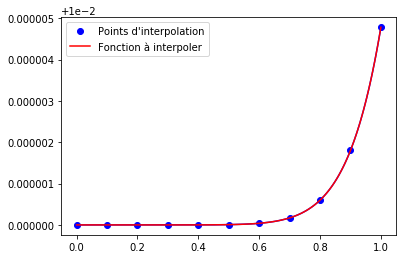

epsilon =  1e-05
Nombre d'itérations finales :  1


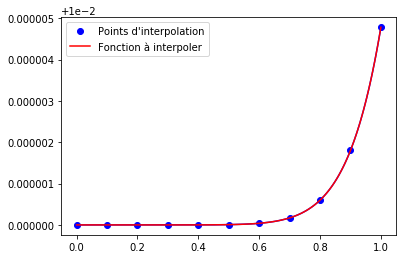

In [194]:
EPS = [0.1,0.01,0.001,0.0001,0.00001]
p = 10
h = 0.1
ERR_int = []

plt.figure()
for j in EPS :
    print("epsilon = ", j)
    poln, xn,err, pol, x, nit = interpol(p ,h, pol4, j)
    polynom_display(xn, poln, x, pol, h, pol4)
    ERR_int += [erreur(xn, poln, pol4, h)]
plt.show()

Ordre =  4.014249609948815


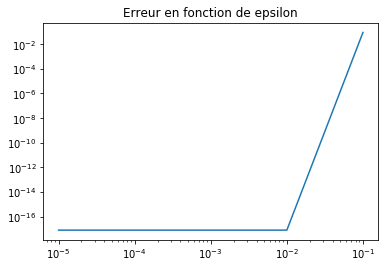

In [195]:
ERR_int = np.asarray(ERR_int)
EPS = np.asarray(EPS)
print("Ordre = ", find_order(EPS,ERR_int))


plt.figure()
plt.loglog(EPS, ERR_int)
plt.title("Erreur en fonction de epsilon")
plt.show()

Quand epsilon est trop haut, l'interpolation de la fonction est mauvaise car le polynome initial est déjà bon.
Quand espilon est trop petit, l'interpolation ne peut plus être prise en charge par le porgramme. 

##### Etude de l'erreur en fonction de H

h =  0.01
Nombre d'itérations finales :  1


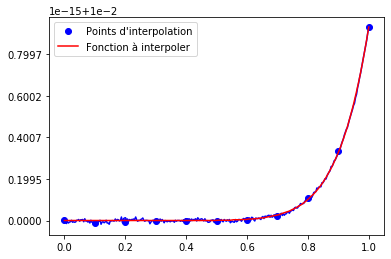

h =  0.03
Nombre d'itérations finales :  1


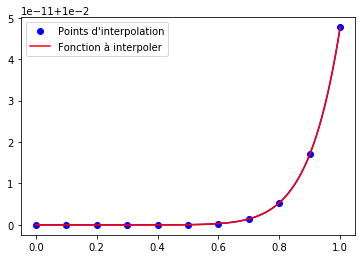

h =  0.06
Nombre d'itérations finales :  1


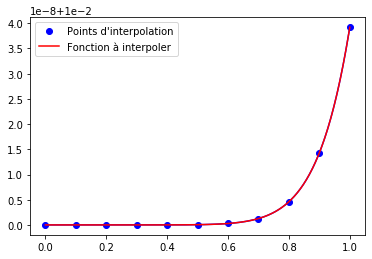

h =  0.1
Nombre d'itérations finales :  1


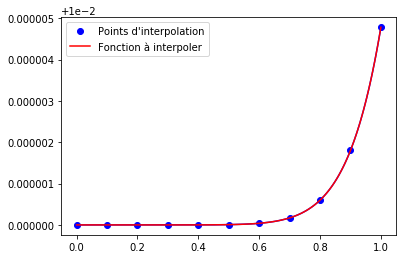

h =  0.13
Nombre d'itérations finales :  1


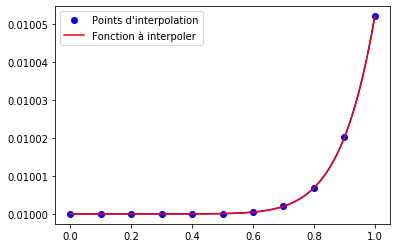

h =  0.16
Nombre d'itérations finales :  1


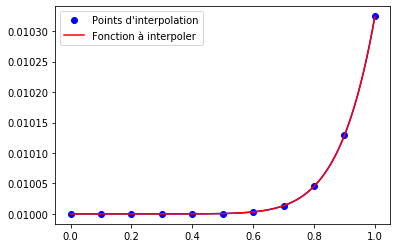

In [196]:
H = [0.01,0.03,0.06,0.1,0.13,0.16]
ERR_int = []

for i in H :
    print("h = ", i)
    poln, xn, err, pol, x, nit = interpol(p ,i, pol4)
    polynom_display(xn, poln,x,pol, i, pol4)
    ERR_int += [erreur(xn, poln, pol4, h)]

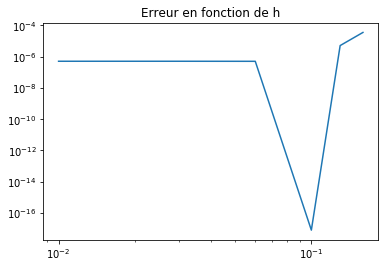

In [197]:
ERR_int = np.asarray(ERR_int)
H = np.asarray(H)
plt.figure()
plt.loglog(H, ERR_int)
plt.title("Erreur en fonction de h")
plt.show()

Quand h devient trop grand, il n'est plus possible de gérer l'interpolation 

##### Etude de l'erreur en fonction de P

P =  5
Nombre d'itérations finales :  9


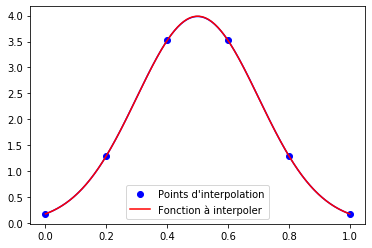

P =  15
Nombre d'itérations finales :  9


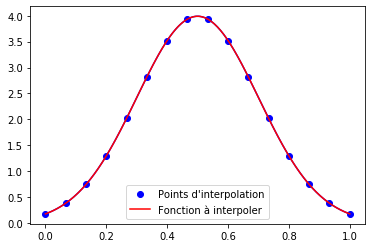

P =  25
Nombre d'itérations finales :  8


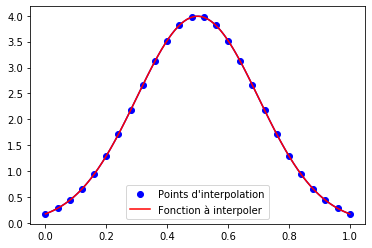

P =  35
Nombre d'itérations finales :  8


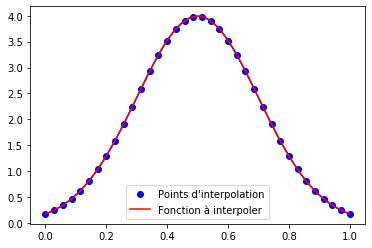

In [198]:
ERR_int = []
P = [5,15,25,35]
for p in P : 
    h = 1/2
    print("P = ", p)
    poln, xn, err, pol, x, nit = interpol(p ,h, gaussienne,1e-4)
    ERR_int += [erreur(xn, poln, pol4, h)]
    polynom_display(xn, poln, x, pol, h, gaussienne)

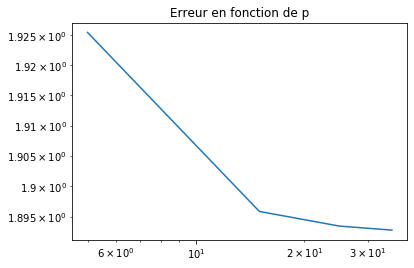

In [199]:
ERR_int = np.asarray(ERR_int)
P = np.asarray(P)
plt.figure()
plt.loglog(P, ERR_int)
plt.title("Erreur en fonction de p")
plt.show()

## Etude de l'ordre d'interpolation entre sinx et sinx + ax +b 

*L'idée est ici de montrer que sin(x) et sin(x) +ax+ b ont le même ordre de convergence même si les points d'interpolation obtenu ne sont pas les mêmes*

h =  0.1
Nombre d'itérations finales :  1


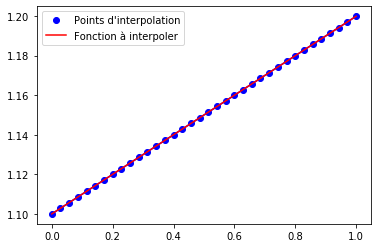

Nombre d'itérations finales :  1


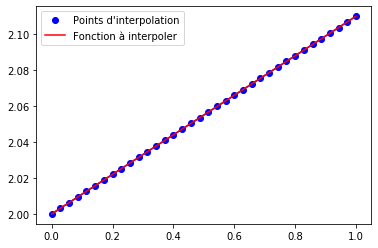

h =  0.05
Nombre d'itérations finales :  1


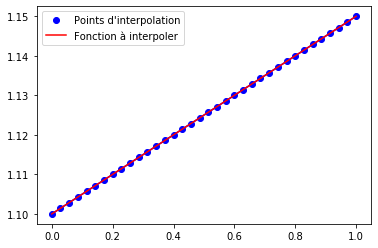

Nombre d'itérations finales :  1


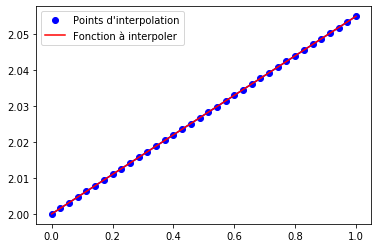

h =  0.01
Nombre d'itérations finales :  1


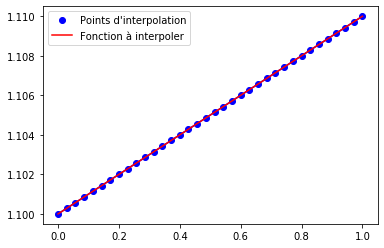

Nombre d'itérations finales :  1


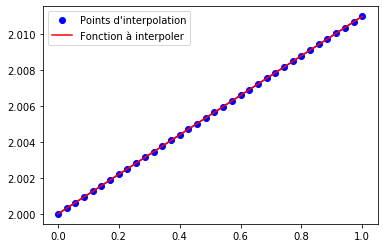

h =  0.005
Nombre d'itérations finales :  1


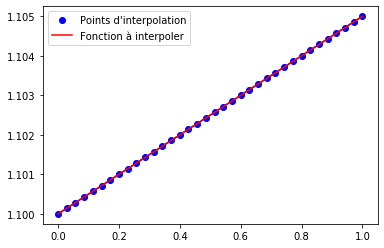

Nombre d'itérations finales :  1


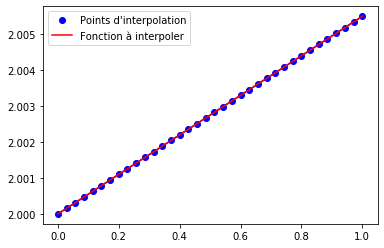

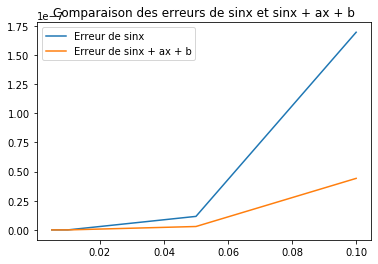

Ordre de la première méthode =  3.94251276244927
Ordre de la seconde méthode =  3.9635702686700363


In [200]:
H = [0.1,0.05,0.01,0.005]
ERR1 = []
ERR2 = []

for h in H : 
    print("h = ", h)
    poln, xn, err, pol, x, nit = interpol(p ,h, sin_off)
    polynom_display(xn, poln,x,pol, h, sin_off)
    ERR1 += [erreur(xn, poln, sin_off, h)]
    
    poln1, xn1, err1, pol1, x1, nit = interpol(p ,h, sin_ax_b)
    polynom_display(xn1, poln1,x1,pol1, h, sin_ax_b)
    ERR2 += [erreur(xn1, poln1, sin_ax_b, h)]

plt.figure()
plt.plot(H,ERR1, label = "Erreur de sinx")
plt.plot(H,ERR2, label = "Erreur de sinx + ax + b")
plt.title("Comparaison des erreurs de sinx et sinx + ax + b")
plt.legend()
plt.show()

print("Ordre de la première méthode = ", find_order(H, ERR1))
print("Ordre de la seconde méthode = ", find_order(H, ERR2))

## Etude des points initiaux différents de Chebytchev

##### Tests avec des points espacés uniformément

In [201]:
def start_point_uni(p):
    I = np.linspace(0.01,1,2*(p+1))
    I = I.reshape((np.shape(I)[0], 1))
    return I

In [202]:
def Newton_Raphson_pts_init(p, h, function, X0, eps=1e-12)  :
    X = np.concatenate((X0[:p], X0[p+2:]))
    X_past = X + 2*eps
    err = 2*eps
    ERR = []
    i = 0
    while npl.norm(X-X_past)/npl.norm(X) > eps and i<20000:
        X_past = X
        X = G_hat(X,h,p,function,eps)
        i+=1
        ERR += [npl.norm(X - X_past)/npl.norm(X)]
    print("Nombre d'itérations finales : ",i)
    #print("Erreur Newton-Raphson : ", ERR[-1])
    return X, ERR

In [203]:
def interpol_pts_init(p, h, function, X0, eps=1e-12) :
    X, ERR = Newton_Raphson_pts_init(p, h, function, X0, eps)
    X = np.concatenate((X[:p], [[1]], [[0]], X[p:]))
    
    xn = np.zeros((p+1,1))
    xn[:,0] = np.linspace(0,1,p+1)
    
    ar = X[:p+1]
    br = X[p+1:]
    
    A = a(xn, ar, h, p, function,eps )
    B = b(xn, br, h, p, function,eps )
    poln = polynom(xn, A, B)

    x = np.linspace(0,1,300)
    A_pol = a(x, ar, h, p ,function, eps)
    B_pol = b(x, br, h, p ,function, eps)
    pol = polynom(x, A_pol, B_pol)

    
    return poln, xn, ERR, pol, x

In [204]:
p = 20
h = 0.08
I = start_point(20)

poln, xn, error, pol, x, nit = interpol_pts_init(p, h, pol1, I)
polynom_display(xn,poln,x ,pol,h,pol1)
print("Valeurs de poln pour des points initiaux qui ne sont pas de la forme de Chebytchev : ", poln[:5])

TypeError: 'numpy.ndarray' object is not callable

In [261]:
def Newton_Raphson_pts_init_t(p, h, function, X0, t, eps=1e-12)  :
    print(X0)
    X = np.concatenate((X0[:p], X0[p+2:]))
    X_past = X + 2*eps
    err = 2*eps
    ERR = []
    i = 0
    while npl.norm(X-X_past)/npl.norm(X) > eps and i<20000:
        X_past = X
        X = G_hat_t(X,h,p,function,eps,t)
        i+=1
        ERR += [npl.norm(X - X_past)/npl.norm(X)]
    print("Nombre d'itérations finales : ",i)
    #print("Erreur Newton-Raphson : ", ERR[-1])
    return X, ERR

In [262]:
def interpol_pts_init_t(p, h, function, X0, t, eps=1e-12) :
    X, ERR = Newton_Raphson_pts_init_t(p, h, function, X0, t, eps)
    X = np.concatenate((X[:p], [[1]], [[0]], X[p:]))
    
    xn = np.zeros((p+1,1))
    xn[:,0] = np.linspace(0,1,p+1)
    
    ar = X[:p+1]
    br = X[p+1:]
    
    A = a(xn, ar, h, p, function,eps )
    B = b(xn, br, h, p, function,eps )
    poln = polynom(xn, A, B)

    x = np.linspace(0,1,300)
    A_pol = a(x, ar, h, p ,function, eps)
    B_pol = b(x, br, h, p ,function, eps)
    pol = polynom(x, A_pol, B_pol)

    
    return poln, xn, ERR, pol, x

*On peut donc constater que lorsque les points initiaux ne sont pas d'une certaine forme, il est beaucoup plus compliqué de trouver des points d'interpolation. En effet, ces points créent des "impossibilitées de calculs*

##### Tests avec des points en Gaussienne

In [205]:
def start_point_gauss(p):
    x = np.linspace(0,1,2*(p+1))
    I = np.exp((-(x - 0.5)**2)/(0.5))-0.2
    I = I.reshape((np.shape(I)[0], 1))
    return I

In [206]:
p = 20
h = 0.08
I = start_point_gauss(p)
poln, xn, error, pol, x, nit = interpol_pts_init(p, h, gaussienne, I)
polynom_display(xn,poln,x ,pol,h,gaussienne)
print("Valeurs de poln pour des points initiaux qui ne sont pas de la forme de Chebytchev : ", poln[:5])

ValueError: math domain error

## Etude de l'erreur des différentes façons de mesurer l'erreur d'interpolation

Nombre d'itérations finales :  5


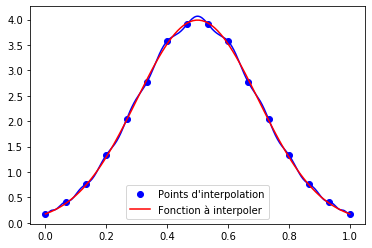

Erreur en npl.norm =  0.13732186393165943
Erreur en quadrature =  0.03076932012878439


In [41]:
p = 15
h = 0.5

poln, xn, err, pol, x, nit = interpol(p ,h, gaussienne,1e-3)
polynom_display(xn, poln, x, pol, h, gaussienne)

print("Erreur en npl.norm = ", npl.norm(poln - gaussienne(xn, h)))
print("Erreur en quadrature = ", erreur(xn, poln, gaussienne,h))

## Schéma advection-diffusion

In [207]:
def u0(x,h) :
    x = x*h
    return np.cos(pi * x)**2 +1 

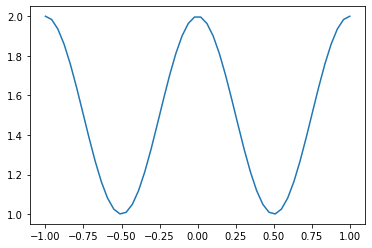

In [208]:
x = np.linspace(-1,1,50)
h = 1 
plt.figure()
plt.plot(x,u0(x,h))
plt.show()

In [209]:
def schema_diffusion (u0, dt, dx, T) :  
    u = np.copy(u0)
    t = 0
    i = 0
    while t<T :
        u_j_1 = np.concatenate(([u[-1]], u[:-1]))
        k = dt/dx
        u = u - k*(u- u_j_1)
        
        t += dt
        i +=1
    return u

Nombre d'itérations finales :  2


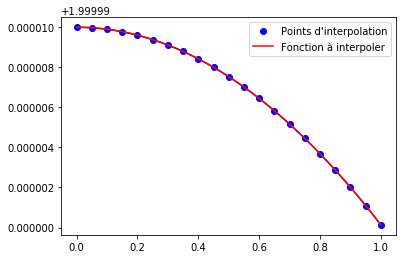

In [212]:
p = 20
h = 0.001
poln, xn, err, pol, x, nit = interpol(p ,h, u0, 1e-12)
polynom_display(xn, poln, x, pol, h, u0)

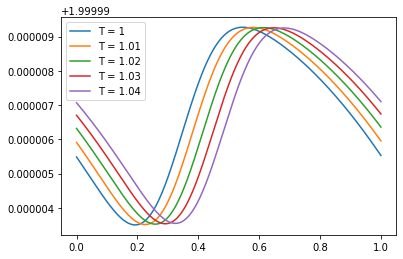

In [213]:
dt = h/20
T = [1,1.01,1.02,1.03,1.04]

plt.figure()
for t in T : 
    u_new_pol = schema_diffusion(pol, dt,h,t)
    plt.plot(x,u_new_pol, label = "T = "+str(t))
plt.legend()
plt.show()

## Diminution du nombre d'itération en prenant en transitoire ? 

In [266]:
# ini = True, reprise de l'init à Tchebytchev à chaque fois
# ini = False, reprise du dernier polynome pour 
def diffusion(dt, Tmax, ini, p, h, function) :
    t=0
    nb_total = 0
    plt.figure()
    while t<Tmax : 
        t+=dt 
        if ini or t == dt :
            poln, xn, err, pol, x, nit = interpol_t(p ,h, function,t, 1e-12)
        else : 
            print(np.shape(poln))
            poln, xn, error, pol, x, nit = interpol_pts_init_t(p, h, function, poln,t)
        nb_total += nit
        plt.plot(xn,poln)
    plt.show()
    return nb_total

##### Sinus diffusant

In [267]:
def sin_t(x, h , t) : 
    x=x*h
    return ( np.sin(x - 10* t) + 2 )

(21, 1)
[[1.15852902]
 [1.1865845 ]
 [1.21667309]
 [1.24871959]
 [1.28264391]
 [1.31836124]
 [1.35578231]
 [1.39481359]
 [1.43535753]
 [1.47731277]
 [1.52057446]
 [1.56503447]
 [1.61058166]
 [1.65710219]
 [1.70447979]
 [1.75259604]
 [1.80133067]
 [1.85056187]
 [1.90016658]
 [1.95002083]
 [2.        ]]


ValueError: could not broadcast input array from shape (0,1) into shape (20,1)

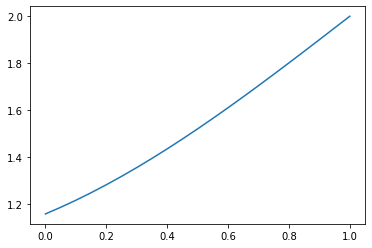

In [268]:
N = diffusion(0.1,1,False, 20, 1, sin_t )
print("Nombre d'itérations totales = ", N)

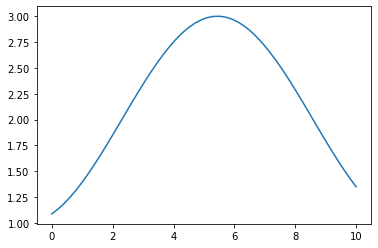

In [227]:
x = np.linspace(0,10,50)
t=2
h= 0.5
plt.figure()
plt.plot(x, sin_t(x,h,t))
plt.show()

Nombre d'itérations finales :  21


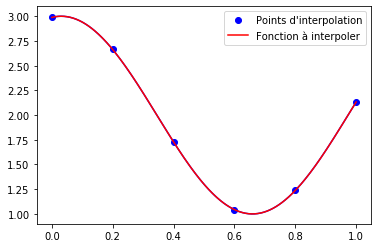

In [228]:
p = 5
h = 5
T = 3

poln, xn, error, pol, x, nit = interpol_t(p, h, sin_t, T)
polynom_display_t(xn,poln,x ,pol,h,sin_t,T)


Nombre d'itérations finales :  21


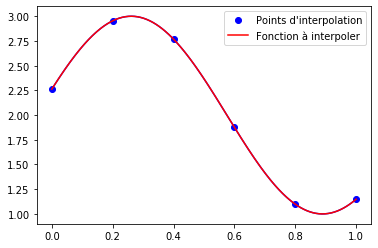

In [217]:
p = 5
h = 5
T = 5

poln, xn, error, pol, x, nit = interpol_t(p, h, sin_t, T)
polynom_display_t(xn,poln,x ,pol,h,sin_t,T)


Même nombre d'itération donc pas d'amélioration même si l'on met une valeur transitoire entre les deux

##### Gaussienne diffusante 

In [251]:
def gauss2_t(x, h, t) : 
    return np.exp ((-(x-0.5)**2)/(0.01*t))

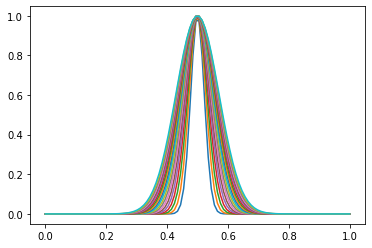

In [252]:
x = np.linspace(0,1,100)
h = 0.5
T = np.linspace(0.1,1,20)
for t in T : 
    plt.plot(x,gauss2_t(x,h,t))

Nombre d'itérations finales :  5


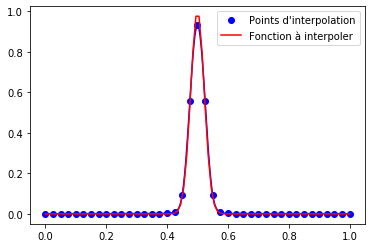

In [254]:
p = 40
h = 0.5
T = 0.1

poln, xn, error, pol, x, nit = interpol_t(p, h, gauss2_t, T)
polynom_display_t(xn,poln,x ,pol,h,gauss2_t,T)


Nombre d'itérations finales :  5


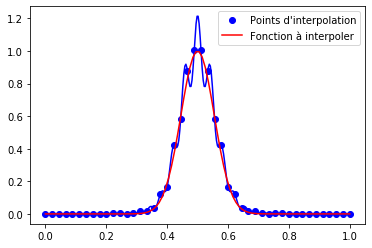

In [257]:
p = 45
h = 0.5
T = 0.6

poln, xn, error, pol, x, nit = interpol_t(p, h, gauss2_t, T)
polynom_display_t(xn,poln,x ,pol,h,gauss2_t,T)


Encore une fois même nombre d'itération finale, docn pas d'amélioration possible.